In [4]:
from abc import ABC, abstractmethod

In [5]:
import yfinance as yf
import pandas as pd

In [6]:
tickers = ["AAPL", "MSFT", "GOOG"]
data= yf.download(tickers, start="2023-01-01", end="2024-01-01")['Adj Close']

[*********************100%***********************]  3 of 3 completed


In [7]:
data.head()

Ticker,AAPL,GOOG,MSFT
Date,,,
2023-01-03,123.768456,89.378845,235.711700
2023-01-04,125.045036,88.392403,225.400925
2023-01-05,123.718979,86.459343,218.720551
2023-01-06,128.271118,87.844376,221.298264
2023-01-09,128.795593,88.482079,223.452866


In [8]:
class Asset(ABC):
    def __init__(self, name):
        self.name = name

    @abstractmethod
    def calculate_return(self):
        pass

In [9]:
class Stock(Asset):
    
    def __init__(self, name, prices):
        super().__init__(name)
        self.prices = prices
        
    def calculate_return(self):
        return self.prices.pct_change().dropna()
        

In [10]:
apple_stock_prices = data['AAPL']
microsoft_stock_prices=data['MSFT']
apple=Stock('apple',apple_stock_prices)
microsoft=Stock('microsoft',microsoft_stock_prices)

In [11]:
apple.calculate_return().mean()

0.0018349273699162089

## Class Portfolio 

In [12]:
import numpy as np
from scipy.optimize import minimize


class Portfolio():
    def __init__(self):
        self._assets=[]
        self._weights=[]
        
    def get_assets(self):
        return self._assets
    
    
    def set_assets(self, assets):
        if not isinstance(assets, list):
            raise TypeError("Les actifs doivent être une liste.")
        self._assets = assets
        
        
        
    def get_weights(self):
        return self._weights
    

    def set_weights(self, weights):
        if not all(0 <= w <= 1 for w in weights):
            raise ValueError("Les poids doivent être entre 0 et 1.")
        if sum(weights) > 1:
            raise ValueError("La somme des poids ne peut pas dépasser 1.")
        self._weights = weights
        
    
    def add_asset(self,asset,weight):
        self._weights.append(weight)
        if not isinstance(asset, Asset):
            raise TypeError("L'objet ajouté doit être une instance de la classe Asset.")
        self._assets.append(asset)
       
        
        
    def portfolio_summary(self):
        details = "Détail du portefeuille :\n"
        for asset, weight in zip(self._assets, self._weights):
            details += f"- {asset.name}: {weight*100:.2f}%\n"
        return details
    
    
    def portfolio_return(self):
        # Calcul du rendement moyen pondéré
        returns = [asset.calculate_return() for asset in self._assets]
        rendement = sum(weight * returns[i].mean() for i, weight in enumerate(self._weights))
        return rendement
    
    
    def portfolio_returns(self):
        all_returns = [asset.calculate_return() for asset in self._assets]

        # Combinaison des rendements pondérés
        weighted_returns = np.sum([returns * weight for returns, weight in zip(all_returns, self._weights)], axis=0)
        return weighted_returns
    

    def portfolio_volatility(self):
        returns=np.array([asset.calculate_return() for asset in self._assets])
        weights=np.array(self._weights)
        cov_mat=np.cov(returns)
        return np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    
        
    ## Optimisation du portfeuille
   
    ## La méthode suivante optimise les pondérations des actifs pour minimiser le risque pour un rendement donné,
    ##   elle retourne les pondérations optimales pour atteindre le rendement cible
    
    
    def optimize_portfolio(self, target_return):
        ### target_return: Rendement cible du portefeuille
            
    
        # Fonction objectif pour minimiser la volatilité
        def objective(weights):
            returns = np.array([asset.calculate_return() for asset in self._assets])
            cov_mat = np.cov(returns)
            portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
            return portfolio_volatility
    
    
        # Contrainte : le rendement du portefeuille doit être égal au rendement cible
        def return_constraint(weights):
            returns = np.array([asset.calculate_return().mean() for asset in self._assets])
            portfolio_return = np.dot(weights, returns)
            return portfolio_return - target_return
        
        # Contrainte : la somme des pondérations doit être égale à 1
        constraints = ({'type': 'eq', 'fun': return_constraint},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # Limites pour les pondérations (entre 0 et 1)
        bounds = [(0, 1) for _ in self._assets]

        # Initialisation des pondérations (également réparties)
        init_weights = np.array([1/len(self._assets) for _ in self._assets])

        # Optimisation des pondérations pour minimiser la volatilité
        result = minimize(objective, init_weights, method='SLSQP', bounds=bounds, constraints=constraints,options={'disp': True,'maxiter': 1000})

        # Enregistrer les pondérations optimales
        if result.success:
            self._weights = result.x
            print(f"Pondérations optimales : {self._weights}")
            return self._weights
        else:
            print("L'optimisation a échoué.")
            return result

       
    ## La méthode suivante optimise les pondérations des actifs pour maximiser le ratio de Sharpe pour un rendement donné,
    ##   elle retourne les pondérations optimales pour atteindre le rendement cible  
        
        
    def optimize_portfolio2(self,target_return):
            
        # Fonction objectif pour minimiser la volatilité
        def negative_sharpe_ratio(weights):
            returns=np.array([asset.calculate_return() for asset in self._assets])
            weights=np.array(weights)
            cov_mat=np.cov(returns)
            std=np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
            rendement = sum(weight * returns[i].mean() for i, weight in enumerate(weights))
            return -rendement/std
    
    
        def return_constraint(weights):
            returns = np.array([asset.calculate_return() for asset in self._assets])
            rendement = sum(weight * returns[i].mean() for i, weight in enumerate(weights))
            return rendement - target_return
        
        # Contrainte : la somme des pondérations doit être égale à 1
        constraints = ({'type': 'eq', 'fun': return_constraint},
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

        # Limites pour les pondérations (entre 0 et 1)
        bounds = [(0, 1) for _ in self._assets]

        # Initialisation des pondérations (également réparties)
        init_weights = np.array([1/len(self._assets) for _ in self._assets])

        # Optimisation des pondérations pour minimiser la volatilité
        result = minimize(negative_sharpe_ratio, init_weights, method='SLSQP', bounds=bounds, constraints=constraints,options={'disp': True,'maxiter': 1000})

        # Enregistrer les pondérations optimales
        if result.success:
            self._weights = result.x
            #print(f"Pondérations optimales : {self._weights}")
            return result
        else:
            print("L'optimisation a échoué.")
            return result
  
        
        

### Détails du portefeuille

In [97]:
portfolio = Portfolio()
portfolio.add_asset(apple,0.5)
portfolio.add_asset(microsoft,0.5)
## Détail du portfeuille
print(portfolio.portfolio_summary())
##Rendement du portfeuille
print(f"Rendement: {portfolio.portfolio_return()}")
## Volatilité du portfeuille
print(f"Volatilité:{portfolio.portfolio_volatility()}")


Détail du portefeuille :
- apple: 50.00%
- microsoft: 50.00%

Rendement: 0.0019032940720102682
Volatilité:0.012514182728994638


### Optimisation du portfeuille en maximisant le ratio de Sharpe

In [98]:
optimal_weights = portfolio.optimize_portfolio2(0.0019)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.15286377729730502
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2


In [99]:
print(portfolio.portfolio_summary())
##Rendement du portfeuille
print(f"Rendement: {portfolio.portfolio_return()}")
## Volatilité du portfeuille
print(f"Volatilité:{portfolio.portfolio_volatility()}")

Détail du portefeuille :
- apple: 52.41%
- microsoft: 47.59%

Rendement: 0.0019000000003547312
Volatilité:0.012429367074054556


### Dans cette partie nous allons donner une liste de rendements cibles à atteindre et nous allons visualiser dans un graphique les portfeuilles optimaux

In [100]:
#Initialisation du portfeuille
portfolio = Portfolio()
portfolio.add_asset(apple,0.5)
portfolio.add_asset(microsoft,0.5)

#Rendements des actifs du portfeuille
mu=[asset.calculate_return().mean() for asset in portfolio._assets]
# Liste de rendements cibles

target_returns = np.linspace(min(mu), max(mu),5)


# Initialisation des listes pour stocker les résultats
weights_list = []
returns_list = []
stds_list = []
sharpe=[]

# Optimisation pour chaque rendement cible
for target in target_returns:
    result=portfolio.optimize_portfolio2(target)
    weights_list.append(portfolio._weights)
    returns_list.append(portfolio.portfolio_return())
    stds_list.append(portfolio.portfolio_volatility())
    sharpe.append(result.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1459761906517222
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.15500507511801942
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.15209096057071678
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.13996890199203374
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12459671035705235
            Iterations: 2
            Function evaluat

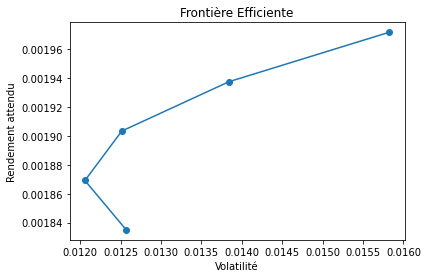

In [101]:
plt.plot(stds_list, returns_list, '-o')
#plt.plot([0, max(stds_list)], [0.0004, max(returns_list)], 'r--')

plt.xlabel('Volatilité')
plt.ylabel('Rendement attendu')
plt.title('Frontière Efficiente')
#plt.axis([0.1, 0.15,0.00175, 0.002])
plt.show()

In [102]:
# Je prends la valeur absolue des ratios de Sharpe pour trouver la valeur maximale
Sharpe = list(map(lambda x: x * -1, sharpe))
# Je prends l'index max du plus grand ratio de sharpe
index_max, valeur_max = max(enumerate(Sharpe), key=lambda x: x[1])
weights_list=np.array(weights_list)
returns_list=np.array(returns_list)
# Calcul du rendement et du risque du portefeuille optimal en se basant sur le meilleur ratio de Sharpe
p_return_max_sharpe = returns_list[index_max]
p_std_max_sharpe = stds_list[index_max]

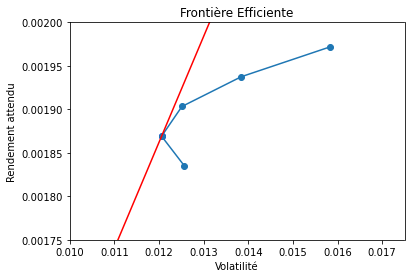

In [103]:
# Tracer la frontière efficiente et la droite de marché
# Tracer la frontière efficiente

risk_free_rate=0.0004
#plt.plot([0, p_std_max_sharpe], [risk_free_rate, p_return_max_sharpe], 'r-', label='Droite de marché')
plt.plot(stds_list, returns_list, '-o')

# Définir un intervalle plus large pour x
x = np.linspace(0, p_std_max_sharpe * 1.5, 100)
# Calculer les valeurs de y correspondantes (en utilisant la bonne équation de la droite)
y = risk_free_rate + (p_return_max_sharpe - risk_free_rate) / p_std_max_sharpe * x
# Tracer la droite
plt.plot(x, y, 'r-', label='Droite de marché')
# Vérifier que la droite passe bien par le point (p_std_max_sharpe, p_return_max_sharpe)
plt.scatter(p_std_max_sharpe, p_return_max_sharpe, color='blue', marker='o')

#plt.annotate(f"Poids: {weights_list[index_max]}", xy=(p_std_max_sharpe, p_return_max_sharpe))

plt.xlabel('Volatilité')
plt.ylabel('Rendement attendu')
plt.title('Frontière Efficiente')
plt.axis([0.01, 0.0175,0.00175, 0.002])
plt.show()

### Optimisation du portfeuille en minimisant la volatilité pour un rendement cible x

In [104]:
#Initialisation du portfeuille
portfolio = Portfolio()
portfolio.add_asset(apple,0.5)
portfolio.add_asset(microsoft,0.5)

#Je prends comme rendement target la rendement optimal, j'aurais normalement les memes resultats
target_return = p_return_max_sharpe
optimal_weights = portfolio.optimize_portfolio(target_return)


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.012058384041530921
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Pondérations optimales : [0.74999995 0.25000005]


In [105]:
print(portfolio.portfolio_summary())
##Rendement du portfeuille
print(f"Rendement: {portfolio.portfolio_return()}")
## Volatilité du portfeuille
print(f"Volatilité:{portfolio.portfolio_volatility()}")

Détail du portefeuille :
- apple: 75.00%
- microsoft: 25.00%

Rendement: 0.0018691107283254913
Volatilité:0.012058384041530921


### Avant de calculer la Var du portfeuille, analysons la distribution des rendments de chaque actifs

In [19]:
from scipy.stats import shapiro, normaltest

In [18]:
import matplotlib.pyplot as plt

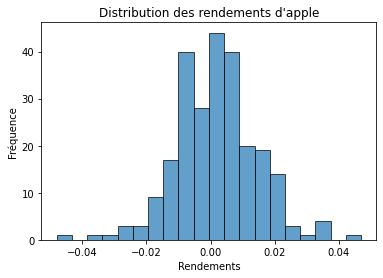

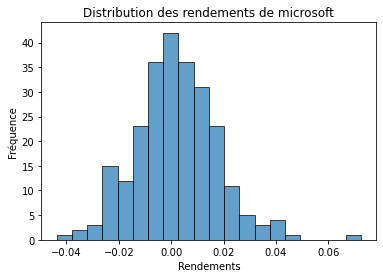

In [230]:
# Histogramme des rendements
apple_returns=apple.calculate_return().dropna()
plt.hist(apple_returns, bins=20, edgecolor='k', alpha=0.7)
plt.title("Distribution des rendements d'apple")
plt.xlabel("Rendements")
plt.ylabel("Fréquence")
plt.show()

# Histogramme des rendements
microsoft_returns=microsoft.calculate_return().dropna()
plt.hist(microsoft_returns, bins=20, edgecolor='k', alpha=0.7)
plt.title("Distribution des rendements de microsoft")
plt.xlabel("Rendements")
plt.ylabel("Fréquence")
plt.show()

In [232]:
#  Test de Shapiro-Wilk pour tester la normalité des rendemets
shapiro_stat, shapiro_p = shapiro(microsoft_returns)
print(f"Shapiro-Wilk Test: Statistique={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Les rendements de microsoft suivent une distribution normale (p > 0.05).")
else:
    print("Les rendements de microsoft ne suivent pas une distribution normale (p <= 0.05).")


Shapiro-Wilk Test: Statistique=0.9855, p-value=0.0124
Les rendements de microsoft ne suivent pas une distribution normale (p <= 0.05).


In [231]:
# 1. Test de Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(apple_returns)
print(f"Shapiro-Wilk Test: Statistique={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Les rendements d'apple  suivent une distribution normale (p > 0.05).")
else:
    print("Les rendements d'apple ne suivent pas une distribution normale (p <= 0.05).")


Shapiro-Wilk Test: Statistique=0.9857, p-value=0.0137
Les rendements d'apple ne suivent pas une distribution normale (p <= 0.05).


In [244]:
shapiro_stat, shapiro_p = shapiro(portfolio_returns)
print(f"Shapiro-Wilk Test: Statistique={shapiro_stat:.4f}, p-value={shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("Les rendements  suivent une distribution normale (p > 0.05).")
else:
    print("Les rendements ne suivent pas une distribution normale (p <= 0.05).")


Shapiro-Wilk Test: Statistique=0.9944, p-value=0.4824
Les rendements  suivent une distribution normale (p > 0.05).


###  QQ-plot pour comparer la distribution empirique avec une distribution normale.

In [26]:
import statsmodels.api as sm

C:\Users\tarik\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


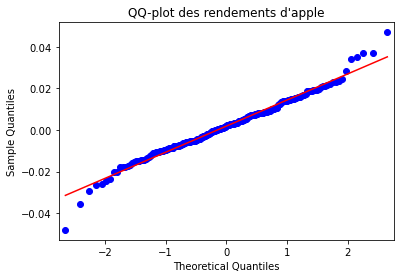

C:\Users\tarik\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


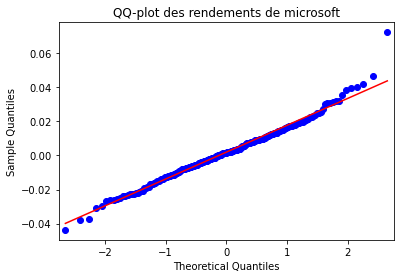

In [233]:

sm.qqplot(apple_returns, line='s')
plt.title("QQ-plot des rendements d'apple")
plt.show()
sm.qqplot(microsoft_returns, line='s')
plt.title("QQ-plot des rendements de microsoft")
plt.show()

##### Skewness is the third moment of a distribution after mean and variance.
Negative skew: The mass of the distribution is concentrated on the right. Usually a right-leaning curve.

Positive skew: The mass of the distribution is concentrated on the left. Usually a left-leaning curve.

In finance, we would tend to want a positive skewness.

In [32]:
from scipy.stats import skew, kurtosis

print(f"Skewness : {skew(apple_returns.dropna())}")  

Skewness : 0.011689421693552004


In [33]:
print(f"Kurtosis : {kurtosis(apple_returns.dropna())}")  

Kurtosis : 1.3802884319996434


#### Ajuster une loi de student sur les rendements d'apple

Le fait d'ajuster une loi (comme la loi t de Student) aux rendements signifie qu'on utilise cette loi pour modéliser les données. Cela se fait en estimant les paramètres de la loi (par exemple, degrés de liberté, moyenne, écart-type) pour qu'elle corresponde au mieux à la distribution observée des rendements (qui ne suivent pas une distribution normale).

L'objectif est de trouver les paramètres optimaux de la loi t de Student (ν,μ,σ) pour qu'elle représente les rendements réels.

La fonction t.fit estime les paramètres suivants :
ν (degrés de liberté) : contrôle l'épaisseur des queues.
μ (loc) : la moyenne des rendements ajustés.
σ (scale) : l'écart-type ajusté.

In [30]:
from scipy.stats import t,norm

# Ajuster une loi t de Student sur les rendements d'apple
data = apple_returns 
df, loc, scale = t.fit(data)  # Paramètres de la loi t
print(f"Degrés de liberté (df): {df}, Location (loc): {loc}, Scale: {scale}")

# Comparer la densité des rendements avec la loi t ajustée

x = np.linspace(min(data), max(data), 100)
pdf = t.pdf(x, df, loc, scale)
plt.hist(data, bins=20, density=True, alpha=0.7, label="Données")
plt.plot(x, pdf, label="Loi t ajustée", color="red")
plt.legend()
plt.show()

NameError: name 'apple_returns' is not defined

#### Ajustement de la VaR et de la CVaR

In [240]:
# Simuler des rendements non normaux (par exemple, loi t)
returns = apple_returns  # Rendements 

# Ajuster les paramètres de la loi t
df, loc, scale = t.fit(returns)

# Calcul de la VaR pour cette distribution
# La VaR à un niveau α est le quantile q=α d'une distribution de pertes
alpha=0.05
VaR_t = t.ppf(0.05, df, loc, scale)

# Calcul de la CVaR pour cette distribution
CVaR_t = t.expect(lambda x: x, args=(df,), lb=-np.inf, ub=VaR, loc=loc, scale=scale) / alpha

print(f"VaR (ajustée) : {VaR_t:.4f}")
print(f"CVaR (ajustée) : {CVaR_t:.4f}")

VaR (ajustée) : -0.0184
CVaR (ajustée) : -0.0240


# Calcul de la Var et de la CVaR du portfeuille

## VaR Historique

In [31]:
portfolio_returns=portfolio.portfolio_returns()

In [32]:
### VAR HISTORIQUE
# Définir le niveau de confiance
# Pour un niveau de confiance de 95 %, le seuil est 5 %
VaR = np.percentile(portfolio_returns, 5)
print(f"Il y a 5% de chance que la perte soit supérieur à {-VaR* 100:.2f}% la valeur du portfeuille")

Il y a 5% de chance que la perte soit supérieur à 1.90% la valeur du portfeuille


In [33]:
CVaR=portfolio_returns[portfolio_returns<VaR].mean()
print(f"CVaR à 5%: {CVaR*100:.2f}%")

CVaR à 5%: -2.18%


## Var Parametrique

In [106]:
mean=portfolio.portfolio_return()
quantile=norm.ppf(0.95, loc =0, scale = 1)
std=portfolio.portfolio_volatility()
VaRp=-(mean+quantile*std)
print(f"Il y a 5% de chance que la perte soit supérieur à {-VaRp* 100:.2f}% la valeur du portfeuille")

Il y a 5% de chance que la perte soit supérieur à 2.17% la valeur du portfeuille


In [107]:
CVaRp=portfolio_returns[portfolio_returns<VaRp].mean()
print(f"CVaR à 5% : {CVaRp*100:.4f}%")

CVaR à 5% : -2.5244%


## Visualiser les seuils de VaR et CVaR sur la distribution des rendements

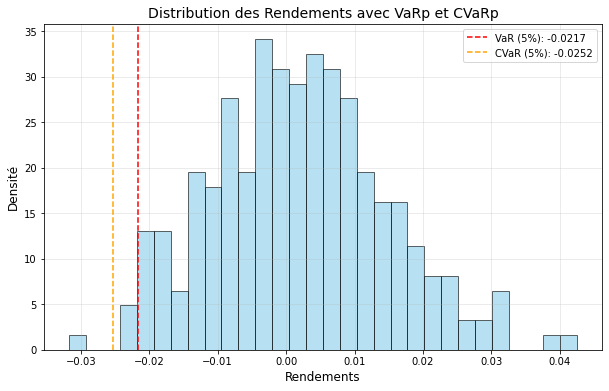

In [108]:
# Création de l'histogramme
alpha=0.05
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Ajouter une ligne verticale pour la VaR
plt.axvline(VaRp, color='red', linestyle='--', label=f"VaR ({alpha*100:.0f}%): {VaRp:.4f}")

# Ajouter une ligne verticale pour la CVaR
plt.axvline(CVaRp, color='orange', linestyle='--', label=f"CVaR ({alpha*100:.0f}%): {CVaRp:.4f}")

# Ajouter des annotations
plt.title("Distribution des Rendements avec VaRp et CVaRp", fontsize=14)
plt.xlabel("Rendements", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.legend(fontsize=10)

# Afficher le graphique
plt.grid(alpha=0.3)
plt.show()

VaR (ligne rouge) :

Indique la perte maximale pour un niveau de confiance donné (α=5%).
Tout ce qui est à gauche de cette ligne représente des pertes extrêmes au-delà du seuil.
CVaR (ligne orange) :

Représente la perte moyenne conditionnelle au dépassement de la VaR.
Elle est plus négative que la VaR, car elle inclut toutes les pertes extrêmes.


In [109]:
# Boucle sur différents niveau de confiance
#for cl, VaR in zip (confidence_levels, VaRs):
#    plt.axvline (x=-VaR, linestyle='-', color='r', label='VaR at {} % Confidence'.format(int(cl* 100)))



Degrés de liberté (df): 159.2932363691105, Location (loc): 0.001891104319940497, Scale: 0.012606572089646013


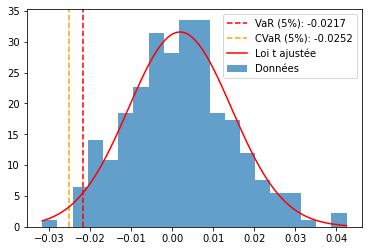

In [110]:
from scipy.stats import t,norm

# Ajuster une loi t de Student sur les rendements
data = portfolio_returns 
df, loc, scale = t.fit(data)  # Paramètres de la loi t
print(f"Degrés de liberté (df): {df}, Location (loc): {loc}, Scale: {scale}")

x = np.linspace(min(data), max(data), 100)
pdf = t.pdf(x, df, loc, scale)
plt.hist(data, bins=20, density=True, alpha=0.7, label="Données")
# Ajouter une ligne verticale pour la VaR
plt.axvline(VaRp, color='red', linestyle='--', label=f"VaR ({alpha*100:.0f}%): {VaRp:.4f}")
# Ajouter une ligne verticale pour la CVaR
plt.axvline(CVaRp, color='orange', linestyle='--', label=f"CVaR ({alpha*100:.0f}%): {CVaRp:.4f}")
plt.plot(x, pdf, label="Loi t ajustée", color="red")
plt.legend()
plt.show()

## Impact de l'optimisation sur la VaR et la CVaR

In [111]:
def var(mean,std,conf):
    quantile=norm.ppf(conf, loc =0, scale = 1)
    return -(mean+quantile*std)

In [112]:
#Initialisation du portfeuille
portfolio = Portfolio()
portfolio.add_asset(apple,0.5)
portfolio.add_asset(microsoft,0.5)

#Rendements des actifs du portfeuille
mu=[asset.calculate_return().mean() for asset in portfolio._assets]
# Liste de rendements cibles
target_returns = np.linspace(min(mu), max(mu),5)

# Initialisation des listes pour stocker les résultats
weights_list = []
returns_list = []
stds_list = []
VaR=[]

# Optimisation pour chaque rendement cible
for target in target_returns:
    portfolio.optimize_portfolio2(target)
    returns_list.append(portfolio.portfolio_return())
    stds_list.append(portfolio.portfolio_volatility())
    VaR.append(var(portfolio.portfolio_return(),portfolio.portfolio_volatility(),0.95))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1459761906517222
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.15500507511801942
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.15209096057071678
            Iterations: 1
            Function evaluations: 3
            Gradient evaluations: 1
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.13996890199203374
            Iterations: 2
            Function evaluations: 6
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.12459671035705235
            Iterations: 2
            Function evaluat

In [113]:
VaR=list(map(lambda x: x * -1, VaR))
VaR

[0.022510812521520804,
 0.021703387455676227,
 0.022487292922130572,
 0.024705868933791654,
 0.028000384590990766]

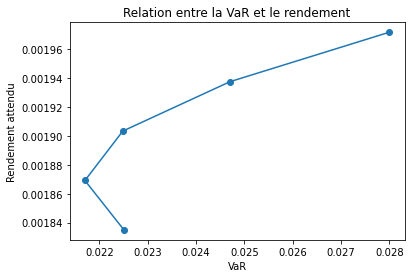

In [114]:
# Visualisation
plt.plot(VaR, returns_list, '-o')
plt.xlabel('VaR')
plt.ylabel('Rendement attendu')
plt.title('Relation entre la VaR et le rendement')
plt.show()

La VaR est en relation linéaire avec la volatilité cette derniére évolue de la meme manière que la volatilité en fonction du rendement